In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from dft.main import Hamiltonian
%config InlineBackend.figure_format = 'retina'

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.32.3792
https://journals.aps.org/prb/pdf/10.1103/PhysRevB.32.3780

In [2]:
from scipy.optimize import fsolve
import numpy as np


class Hamiltonian:
    """
    Simple plane wave DFT class.

    Example:
    ```
    h = Hamiltonian(Npw=100, L=5, Nel=7)
    for _ in range(10):
        h.rho = rho_in
        rho_out = h.get_rho()
        rho_in = rho_out
    ```
    """
    def __init__(self, Npw, L, Znuc, beta2=1.5**2, pos=0.625, kT=1e-3, min_focc=1e-12):
        """
        Args:
            Npw (int): Number of plane waves
            L (float): Box length
            Znuc (int): Number of protons (currently also number of electrons)
            beta2 (float): Gaussian width of the core
            pos (float): Relative position of the core
            kT (float): Boltzmann factor times temperature
            min_focc (float): Minimum occupancy to consider for the energy calculation
        """
        self.Npw = Npw
        self.L = L
        self._Gvec = None
        self._Gvec_2 = None
        self._coulomb = None
        self.pos = pos * L
        self.beta2 = beta2
        self.Znuc = Znuc
        self.Nel = Znuc
        self._rhonuc_G = None
        self._rho = None
        self._rho_G = None
        self.kT = kT
        self._mu = None
        self._vals = None
        self._vecs = None
        self._min_focc = min_focc

    @property
    def rhonuc_G(self):
        if self._rhonuc_G is None:
            self._rhonuc_G = -(self.Znuc / self.L) * np.exp(
                1j * self.Gvec_2 * self.pos
            ) * np.exp(-0.5 * self.Gvec_2**2 * self.beta2)
        return self._rhonuc_G

    @property
    def coulomb(self):
        if self._coulomb is None:
            self._coulomb = np.zeros(len(self.Gvec_2))
            cond = np.abs(self.Gvec_2) > 1e-10
            self._coulomb[cond] = 4 * np.pi / self.Gvec_2[cond]**2
        return self._coulomb

    @property
    def Gvec(self):
        if self._Gvec is None:
            self._Gvec = np.fft.fftfreq(self.Npw, d=self._dL) * (2 * np.pi)
        return self._Gvec

    @property
    def Gvec_2(self):
        if self._Gvec_2 is None:
            self._Gvec_2 = np.fft.fftfreq(2 * self.Npw, d=self._dL / 2) * (2 * np.pi)
        return self._Gvec_2

    @property
    def _dL(self):
        return self.L / self.Npw

    @property
    def _G_indices(self):
        ni = np.roll(np.arange(self.Npw) + 1 - self.Npw // 2, self.Npw // 2 + 1)
        return ni[:, None] - ni

    @property
    def ham_mat(self):
        return np.fft.ifft(self.v_eff)[self._G_indices] + 0.5 * self.Gvec**2 * np.eye(self.Npw)

    def _get_fermi(self, x):
        x = np.atleast_1d(x)
        results = np.zeros_like(x)
        cond = (x / self.kT < 50)
        results[cond] = 1 / (1 + np.exp(x[cond] / self.kT))
        return results.squeeze()

    def _target_mu(self, mu):
        return np.sum(self._get_fermi(self.vals - mu)) - self.Nel

    @property
    def mu(self):
        if self._mu is None:
            self._mu, = fsolve(self._target_mu, x0=self.vals[self.Nel])
        return self._mu

    @property
    def vals(self):
        if self._vals is None:
            self._vals, self._vecs = np.linalg.eigh(self.ham_mat)
        return self._vals

    @property
    def _vals_trunc(self):
        return self.vals[self.focc > self._min_focc]

    @property
    def vecs(self):
        if self._vecs is None:
            self._vals, self._vecs = np.linalg.eigh(self.ham_mat)
        return self._vecs

    @property
    def _vecs_trunc(self):
        return self.vecs[:, self.focc > self._min_focc]

    @vals.setter
    def vals(self, v):
        self._mu = None
        self._vals = v

    @vecs.setter
    def vecs(self, v):
        self._vecs = v

    @property
    def focc(self):
        return self._get_fermi(self.vals - self.mu)

    @property
    def _focc_trunc(self):
        return self.focc[self.focc > self._min_focc]

    def get_rho(self):
        psi_expand = np.zeros(shape=(2 * self.Npw, len(self._focc_trunc))) * 1j
        psi_expand[0:self.Npw // 2] = self._vecs_trunc[0:self.Npw // 2]
        psi_expand[-self.Npw // 2:] = self._vecs_trunc[-self.Npw // 2:]
        psi = np.fft.fft(psi_expand, axis=0) / np.sqrt(self.L)
        return np.sum(np.absolute(psi)**2 * self._focc_trunc, axis=-1)

    @property
    def e_kin(self):
        return 0.5 * np.einsum(
            'j,ij,i->', self._focc_trunc, np.absolute(self._vecs_trunc)**2, self.Gvec**2,
            optimize=True
        )

    @property
    def rho(self):
        """Input charge density. For the output charge density, use `get_rho()`."""
        return self._rho

    @rho.setter
    def rho(self, rho_in):
        self._rho = np.array(rho_in)
        self._rho_G = None
        self._mu = None
        self._vals = None
        self._vecs = None

    def get_rho_G(self, include_core=True):
        if self._rho_G is None:
            self._rho_G = np.fft.ifft(self.rho)
        rho_G = self._rho_G.copy()
        if include_core:
            rho_G += self.rhonuc_G
        rho_G[0] = 0.
        return rho_G

    @property
    def _alpha(self):
        return -3 / 4 * (3 / np.pi) ** (1 / 3)

    @property
    def e_xc(self):
        return np.sum(self.rho[self.rho > 0]**(4. / 3.)) * self._alpha * self._dL / 2

    @property
    def v_xc(self):
        return (4. / 3.) * self._alpha * np.maximum(self.rho, 0)**(1. / 3.)

    @property
    def v_G(self):
        return self.get_rho_G(include_core=True) * self.coulomb

    @property
    def v_H(self):
        return np.real(np.fft.fft(self.v_G))

    @property
    def v_eff(self):
        return self.v_H + self.v_xc

    @property
    def v_loc(self):
        return self.coulomb * self.rhonuc_G

    @property
    def e_loc(self):
        return np.vdot(self.get_rho_G(include_core=False), self.v_loc).real * self.L

    @property
    def e_Ewald(self):
        return 0.5 * np.vdot(self.rhonuc_G, self.v_loc).real * self.L

    @property
    def e_H(self):
        return 0.5 * np.vdot(
            self.get_rho_G(include_core=False), self.get_rho_G(include_core=False) * self.coulomb
        ).real * self.L

    @property
    def e_tot(self):
        return self.e_kin + self.e_xc + self.e_H + self.e_loc + self.e_Ewald

    @property
    def S_G(self):
        return np.exp(1j * self.Gvec_2 * self.pos)

    @property
    def dvloc_dGGG(self):
        return 2 * (self.Znuc / self.L) * np.exp(
            -0.5 * self.Gvec_2**2 * self.beta2
        ) * self.coulomb * (1 + 0.5 * self.beta2 * self.Gvec_2**2)

    @property
    def p_Ewald(self):
        return 1 / self.L**2 / 2 * np.sum(self.coulomb * np.exp(
            -self.Gvec_2**2 * self.beta2
        ) * self.Znuc**2 * (2 * self.beta2 * self.Gvec_2**2 + 1)) + 2 * np.pi * self.beta2 / self.L**2 * self.Znuc**2

    @property
    def p_kin(self):
        return np.einsum(
            'j,ij,i->', self._focc_trunc, np.absolute(self._vecs_trunc)**2, self.Gvec**2,
            optimize=True
        ) / self.L

    @property
    def p_el(self):
        return -0.5 * np.vdot(self.get_rho_G(include_core=False), self.get_rho_G(include_core=False) * self.coulomb).real

    @property
    def p_loc(self):
        return -np.vdot(self.S_G * (self.dvloc_dGGG + self.v_loc), self.get_rho_G(include_core=False)).real

    @property
    def p_xc(self):
        return (self.e_xc - np.sum(self.rho * self.v_xc) * self._dL / 2) / self.L


In [3]:
def get_rho0(h):
    rho0b2 = 1.2**2
    rho0_G = (1./h.L) * np.exp(1j * h.Gvec_2 * h.pos) \
                  * np.exp(-0.5 * h.Gvec_2**2 * rho0b2)
    rho0 = np.fft.fft(rho0_G).real
    rho0 *= h.Nel
    return rho0

In [4]:
def scf_cycle(ham, rho_in):
    ham.computePot (rho_in)
    return ham.get_rho()

In [5]:
def run_scf(h, rho_i=None, pre_scale=0.8, max_steps=50):
    if rho_i is None:
        rho_i = get_rho0(h)
    allRes = []
    allE = []
    res_old=None
    search_old=None
    gamma = 0.
    for i in range(max_steps):
        h.rho = rho_i
        rho_o = h.get_rho()
        res = rho_o-rho_i
        allRes.append (np.linalg.norm(res))
        # h.rho = rho_o
        allE.append (h.e_tot)

        if allRes[-1] < 1e-10:
            break

        # conjugate-gradient for density (not sure this works in all cases!)
        # should be DIIS or MINRES
        search = res
        if search_old is not None:
            gamma = np.dot(res_old, res)/np.dot(res_old, res_old)
            search += gamma * search_old
        search_old = search
        res_old = res

        # line search
        rho_trial = rho_i + pre_scale * search
        h.rho = rho_trial
        resTrial = h.get_rho() - rho_trial
        step = -np.dot(resTrial-res, res) /np.dot(resTrial-res,resTrial-res)

        # optimal step
        rho_i = rho_i + step * pre_scale * search

        # dynamic adaptation of pre_scale
        if (step > 2):
            pre_scale *= 1.5
        elif (step < 0.5):
            pre_scale /= 1.5
    return allE, allRes

In [6]:
Npw = 150
L = 5
Nel = 7
E_lst = []
p_tot_lst = []
E_tot_lst = []
R_lst = []
L_lst = np.linspace(7.5, 8, 11)
for L in tqdm(L_lst):
    h = Hamiltonian(Npw, L, Nel)
    E, R = run_scf(h)
    E_lst.append(E[-1])
    R_lst.append(R[-1])
    E_tot_lst.append([h.e_kin, h.e_H, h.e_xc])
    p_kin = np.einsum(
            'j,ij,i->', h._focc_trunc, np.absolute(h._vecs_trunc)**2, h.Gvec**2,
            optimize=True
        ) / h.L
    p_tot_lst.append([h.p_kin, h.p_el, h.p_loc, h.p_Ewald, h.p_xc])

p_tot_lst = np.array(p_tot_lst)
E_tot_lst = np.array(E_tot_lst)

100%|██████████| 11/11 [00:28<00:00,  2.57s/it]


In [7]:
def get_fit(L_lst, E_lst, derivative=False, order=3, n_points=100):
    coeff = np.polyfit(L_lst, E_lst, order)
    L = np.linspace(L_lst.min(), L_lst.max(), n_points)
    if derivative:
        return L, np.polyval(np.polyder(coeff), L)
    return L, np.polyval(coeff, L)

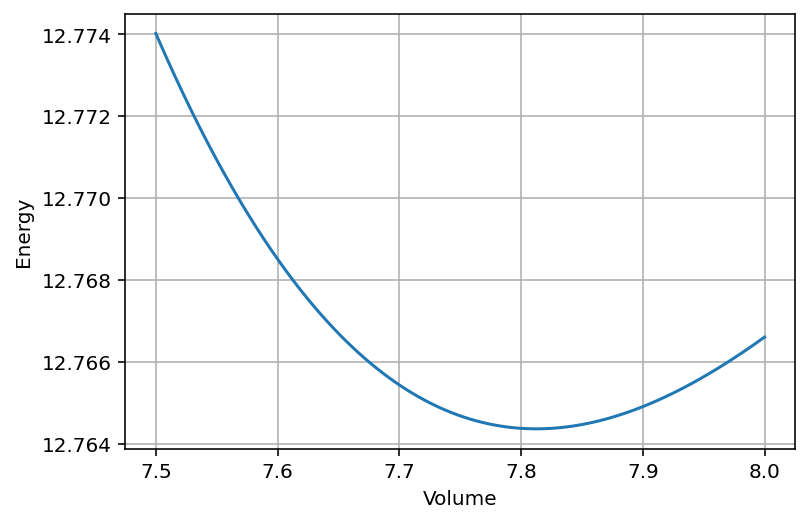

In [8]:
plt.grid()
plt.xlabel('Volume')
plt.ylabel('Energy')
plt.plot(*get_fit(L_lst, E_lst, derivative=False));

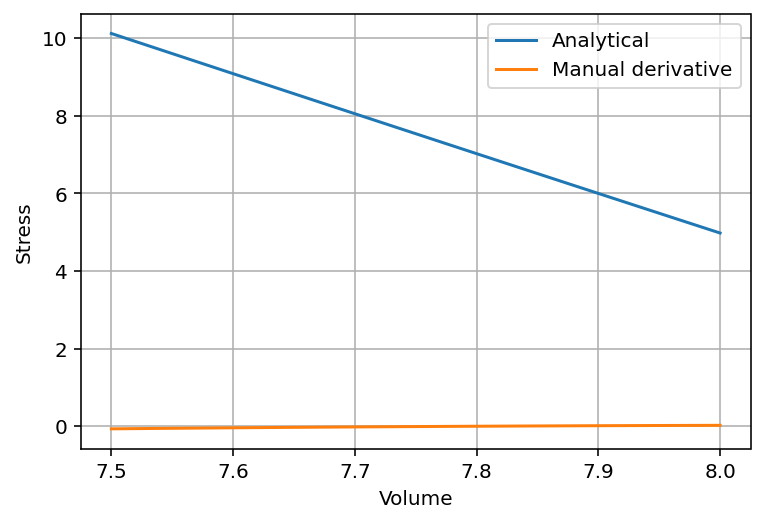

In [9]:
plt.grid()
plt.xlabel('Volume')
plt.ylabel('Stress')
plt.plot(*get_fit(L_lst, np.sum(p_tot_lst, axis=-1)), label='Analytical')
plt.plot(*get_fit(L_lst, E_lst, derivative=True), label='Manual derivative')
plt.legend();